In [29]:
import os
import pylab as plt

t1_file = os.path.join(os.getcwd(), 'T1_preprocessed.nii.gz')
t2_file = os.path.join(os.getcwd(), 'T2_preprocessed.nii.gz')
flair_file = os.path.join(os.getcwd(), 'FLAIR_preprocessed.nii.gz')

import nibabel as nib
t1_img = nib.load(t1_file)
t2_img = nib.load(t2_file)
flair_img = nib.load(flair_file)

t1_data = t1_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()

## T1, T2 and FLAIR modalities

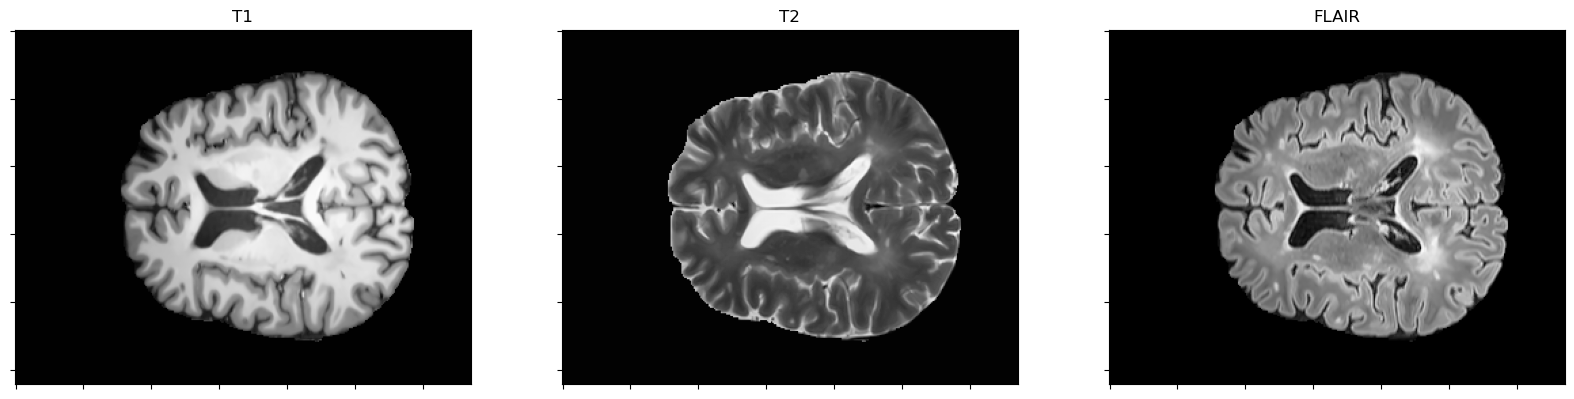

In [30]:
fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.title.set_text('T1')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.imshow(t1_data[:, :, 218], cmap="Greys_r")

ax2 = fig.add_subplot(1, 3, 2)
ax2.title.set_text('T2')
ax2.set_yticklabels([])
ax2.set_xticklabels([])
plt.imshow(t2_data[:, :, 218], cmap="Greys_r")

ax3 = fig.add_subplot(1, 3, 3)
ax3.title.set_text('FLAIR')
ax3.set_yticklabels([])
ax3.set_xticklabels([])
plt.imshow(flair_data[:, :, 218], cmap="Greys_r")

## RGB Images

Make RGB Images by using permutations of (T1, T2, FLAIR) on the R G B channels. 

For example, an image can be generated using T1 on the R channel, T2 on the G channel and FLAIR on the B channel.
Values of the pixels for each modality need to be normalized and scaled before computing the RGB image.

In [9]:
from PIL import Image
import numpy as np

RGB_IMAGES_OUTPUT_FOLDER = os.path.join(os.getcwd(), "rgb_images")

def normalize(im):
    # Normalize image to range 0..1
    min, max = im.min(), im.max()
    return (im.astype(float)-min)/(max-min)

im1 = t1_data[:, :, 218]
im2 = t2_data[:, :, 218]
im3 = flair_data[:, :, 218]

# Normalize and scale
n1 = normalize(im1) * 255.999
n2 = normalize(im2) * 255.999
n3 = normalize(im3) * 255.999

my_array = np.array([n1, n2, n3])

def index_to_type(index):
    if index == 0: return "T1"
    if index == 1: return "T2"
    if index == 2: return "FLAIR"

images = []

from pathlib import Path
Path(RGB_IMAGES_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

# compute permutations
for x in range(3):
    for y in range(3):
        for z in range(3):
            if x == y or x == z or z == y: continue

            permuted_array = my_array[[x, y, z]]

            result = np.dstack((permuted_array[0], permuted_array[1], permuted_array[2]))
            result = Image.fromarray(result.astype(np.uint8))
            images.append(result)

            result_name = index_to_type(x) + '_' + index_to_type(y) + '_' + index_to_type(z) + '.png'
            result_final_path = os.path.join(RGB_IMAGES_OUTPUT_FOLDER, result_name)
            result.save(result_final_path)

## Graph class

The graph will be represented by an adjacency list.

In [10]:
class Node:
    def __init__(self, value):
        self.vertex = value
        self.next = None
        self.weight = None

class Graph:
    def __init__(self, num):
        self.V = num
        self.graph = [None] * self.V

    def add_edge(self, s, d, w):
        node = Node(d)
        node.next = self.graph[s]
        node.weight = w
        self.graph[s] = node

    def __print_graph(self, file=None):
        for i in range(self.V):
            print("Vertex " + str(i) + ":", end="", file=file)
            temp = self.graph[i]
            while temp:
                print(" -> {}, w:{}".format(temp.vertex, temp.weight), end="", file=file)
                temp = temp.next
            print(" \n", file=file)

    def print_graph(self):
        self.__print_graph()

    def print_graph_to_file(self, filename):
        with open(filename, 'w') as f:
            self.__print_graph(file=f)

## Build the graph for each RGB image previously generated

In [11]:
import math

def compute_pixel_graph(image):
    max_row = image.height
    max_col = image.width

    image = list(image.getdata())

    graph = Graph(len(image))

    def is_pixel_black(pixel):
        return pixel == (0, 1, 2) or pixel == (0, 2, 1) or pixel == (1, 0, 2) or pixel == (1, 2, 0) or pixel == (2, 1, 0) or pixel == (2, 0, 1)

    def compute_rgb_distance(rgb1, rgb2):
        r_sq = math.pow((rgb2[0] - rgb1[0]), 2)
        g_sq = math.pow((rgb2[1] - rgb1[1]), 2)
        b_sq = math.pow((rgb2[2] - rgb1[2]), 2)

        return math.sqrt(r_sq + g_sq + b_sq)

    def add_edges_for_adjacent_pixels(row, col):
        idx = col + (row * max_col)
        if row > 0 and col > 0:
            top_left_idx = (col - 1) + ((row - 1) * max_col)
            if not is_pixel_black(image[top_left_idx]):
                weight = compute_rgb_distance(image[idx], image[top_left_idx])
                graph.add_edge(idx, top_left_idx, weight)

        if row > 0:
            top_mid_idx = col + ((row - 1) * max_col)
            if not is_pixel_black(image[top_mid_idx]):
                weight = compute_rgb_distance(image[idx], image[top_mid_idx])
                graph.add_edge(idx, top_mid_idx, weight)

        if row > 0 and col < max_col - 1:
            top_right_idx = (col + 1) + ((row - 1) * max_col)
            if not is_pixel_black(image[top_right_idx]):
                weight = compute_rgb_distance(image[idx], image[top_right_idx])
                graph.add_edge(idx, top_right_idx, weight)

        if row < max_row - 1 and col != 0:
            bottom_left_idx = (col - 1) + ((row + 1) * max_col)
            if not is_pixel_black(image[bottom_left_idx]):
                weight = compute_rgb_distance(image[idx], image[bottom_left_idx])
                graph.add_edge(idx, bottom_left_idx, weight)

        if row < max_row - 1:
            bottom_mid_idx = col + ((row + 1) * max_col)
            if not is_pixel_black(image[bottom_mid_idx]):
                weight = compute_rgb_distance(image[idx], image[bottom_mid_idx])
                graph.add_edge(idx, bottom_mid_idx, weight)

        if row < max_row - 1 and col < max_col - 1:
            bottom_right_idx = (col + 1) + ((row + 1) * max_col)
            if not is_pixel_black(image[bottom_right_idx]):
                weight = compute_rgb_distance(image[idx], image[bottom_right_idx])
                graph.add_edge(idx, bottom_right_idx, weight)
        
        if col > 0:
            mid_left_idx = (col - 1) + (row * max_col)
            if not is_pixel_black(image[mid_left_idx]):
                weight = compute_rgb_distance(image[idx], image[mid_left_idx])
                graph.add_edge(idx, mid_left_idx, weight)
        
        if col < max_col - 1:
            mid_right_idx = (col + 1) + (row * max_col)
            if not is_pixel_black(image[mid_right_idx]):
                weight = compute_rgb_distance(image[idx], image[mid_right_idx])
                graph.add_edge(idx, mid_right_idx, weight)


    for row in range(max_row):
        for col in range(max_col):
            idx = col + (row * max_col)
            if not is_pixel_black(image[idx]):
                add_edges_for_adjacent_pixels(row, col)
    
    return graph

In [12]:
import os
from pathlib import Path

IMAGES_GRAPHS_OUTPUT_FOLDER = os.path.join(os.getcwd(), "graphs")

Path(IMAGES_GRAPHS_OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

def drop_extension_from_filename(filename):
    return os.path.splitext(filename)[0]

for filename in os.listdir(RGB_IMAGES_OUTPUT_FOLDER):
    with (Image.open(os.path.join(RGB_IMAGES_OUTPUT_FOLDER, filename))) as image:
        graph = compute_pixel_graph(image)
        graph.print_graph_to_file(os.path.join(IMAGES_GRAPHS_OUTPUT_FOLDER, drop_extension_from_filename(filename) + ".txt"))